# Sets Analysis

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np

## Subset of citations

In [2]:
all_citations = pd.read_csv('../inputdata/all_cases_citations.csv')
print('Total citations relations EUR-LEX: ',len(all_citations))

Total citations relations EUR-LEX:  43780


In [3]:
sampled_cases = pd.read_csv('../inputdata/sampled_cases.csv').rename(columns={'source':'case'})
print('Total sampled cases for the study: ',len(sampled_cases))

Total sampled cases for the study:  177


In [325]:
sampled_cases.head()

,quantile,case,citations,topic
0,1.00,61990CJ0006,43,social policy
1,1.00,62003CJ0453,32,public health
2,0.99,62007CJ0378,32,social policy
3,0.98,61995CJ0261,19,social policy
4,1.00,62000CJ0465,17,data protection


In [327]:
print(
len(sampled_cases[sampled_cases['topic']=='social policy']),
len(sampled_cases[sampled_cases['topic']=='public health']),
len(sampled_cases[sampled_cases['topic']=='data protection'])
)


85 63 29


---
## Functions 

In [5]:
#Creating all unique nodes of the graph (this nodes catakogue works for both graphs)
def df_to_json_nodes(df_relations, df_attributes, node_name = 'case'):
    """"Assumes the columns are called source and target"""
    nodes_list = []; nodes = pd.DataFrame()
    nodes_list.extend(list(df_relations.source.unique()))
    nodes_list.extend(list(df_relations.target.unique()))
    nodes[str(node_name)] = list(set(nodes_list))
    nodes = pd.merge(nodes, df_attributes, how='left').fillna('NA')
    nodes = nodes.set_index(str(node_name)).to_dict('index')
    return nodes

In [6]:
#Graph description
def graph_description(g):
    N_nodes, N_edges = g.order(), g.size()
    avg_deg = float(N_nodes)/N_edges
    print ('Nodes: {}\nEdges: {}\nAvg Degree: {}'.format(N_nodes, N_edges, avg_deg) )

In [7]:
#Get the graph and layout, works only for this dataset
def graph_and_layout(df, nodes):
    #Assumes the relations are called source and target
    g = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr=True) #, create_using = nx.DiGraph)
    nx.set_node_attributes(g, nodes)
    return g

In [8]:
#goupings the colors
def groups(g):
    group0 = []
    group1 = []
    group2 = []
    group3 = []
    for n in g.nodes():
        if g.node[str(n)]['topic'] == "NA":
            group0.append(n)
        elif g.node[str(n)]['topic'] == "social policy":
            group1.append(n)
        elif g.node[str(n)]['topic'] == "public health":
            group2.append(n)
        elif g.node[str(n)]['topic'] == "data protection":
            group3.append(n)
        else:
            print(n)
    return group0, group1, group2, group3

In [9]:
def plot_graph(g, pos, groups, edges_groups):
    plt.figure(figsize=(16, 12))
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[0],
                           node_color="#878787", #gray
                           node_size=10,
                           linewidths = 3,
                           alpha=0.3)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[1],
                           node_color="#3f59bf", #blue "social policy"
                           node_size=30,
                           alpha=0.8)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[2],
                           node_color="#bfb71f",  #yellow "public health"
                           node_size=30,
                           alpha=0.8)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[3],
                           node_color="#3ecc0e", #green "data protection"
                           node_size=30,
                           alpha=0.8)
    nx.draw_networkx_edges(g,pos,
                           edgelist=edges_groups[0],
                           width=0.5,alpha=0.5,edge_color='gray')
    nx.draw_networkx_edges(g,pos,
                           edgelist=edges_groups[1],
                           width=1,alpha=0.8,edge_color='red')
    #nx.draw_networkx_edges(g,pos,width=0.5,alpha=0.5, arrows=False, arrowstyle="Arc3, rad=-0.2")
    plt.show()

---
## Citations Graph

#### Taking the subset of the whole citations files where the target OR the source is in the sample

In [10]:
all_citations['sample_in_source'] = [1 if i in list(sampled_cases.case) else 0 for i in all_citations['source']]
all_citations['sample_in_target'] = [1 if i in list(sampled_cases.case) else 0 for i in all_citations['target']]

In [11]:
citations_subset = all_citations[(all_citations['sample_in_source'] == 1) | (all_citations['sample_in_target'] == 1)]
citations_subset = citations_subset[['source','target']]

In [12]:
print('Total citations relations sampled from EUR-LEX: ',len(citations_subset))

Total citations relations sampled from EUR-LEX:  1174


In [13]:
citations_subset.head()

,source,target
188,62016CJ0384,61962CJ0025
286,62007CO0073,61964CO0006
334,61996CJ0416,61965CJ0061
404,61996CJ0050,61968CJ0014
535,61987CJ0187,61970CJ0009


---
#### Creating the citations graph

In [14]:
nodes = df_to_json_nodes(df_relations = citations_subset,
                         df_attributes = sampled_cases[['case','topic']])
g = graph_and_layout(citations_subset, nodes) #the df of relations again
pos = nx.spring_layout(g) #nx.kamada_kawai_layout(g2)
graph_description(g)

Nodes: 1031
Edges: 1172
Avg Degree: 0.8796928327645052


In [15]:
g_rest, g_SP, g_PH, g_DP = groups(g)

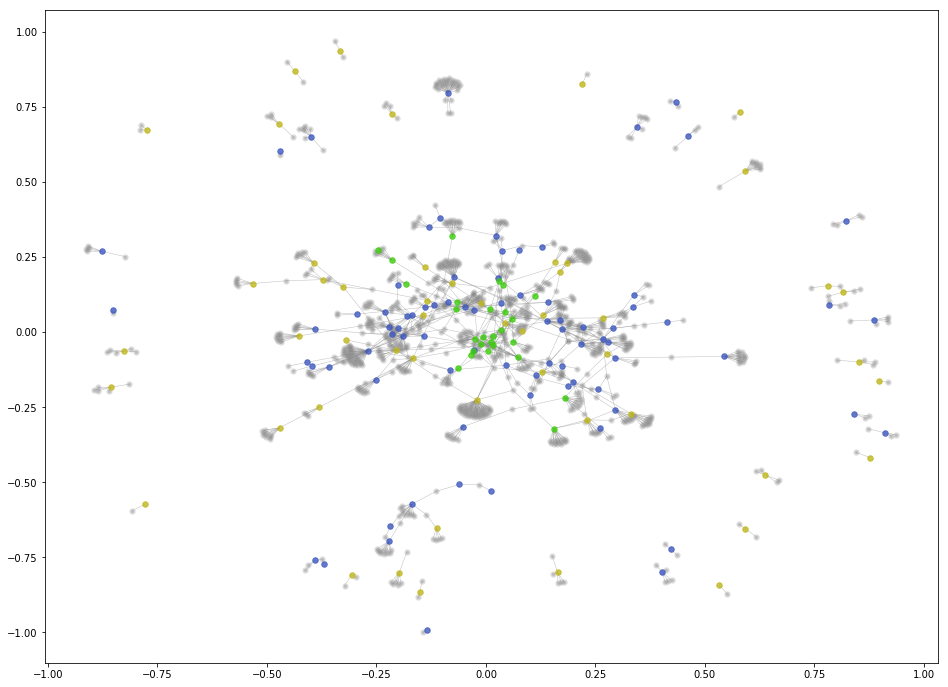

In [17]:
plot_graph(g,pos,
           [g_rest, g_SP, g_PH, g_DP],
           [[(s,t) for s, t, att in g.edges.data()],[]])

---
## Similarity Graph

#### Filtering relevant algorithmns

In [123]:
models = pd.read_csv('../inputdata/models.csv')
models

,Similarity Type,Similarity Method,Model,method
0,Syntactic,Index,TF-IDF Quintgrams,tfidf-quintgram-nostem
1,Syntactic,Index,Jaccard Distance,jaccard
2,Syntactic,Index,TF-IDF,tfidf-nostem
3,Semantic,Cosine Similarity,Doc2Vec Embeddings,doc2vec_256_e30
4,Semantic,Cosine Similarity,Law2Vec Embeddings,law2vec_200
5,Semantic,Cosine Similarity,GoogleNews Embeddings,GoogleNews_300
6,Semantic,Word Mover's Distance,Doc2Vec Embeddings,WMD_256_e30
7,Semantic,Word Mover's Distance,Law2Vec Embeddings,Law2Vec-200-WMD
8,Semantic,Word Mover's Distance,GoogleNews Embeddings,GoogleNews-300-WMD


In [124]:
casses_similarity = pd.read_csv('../outputdata/results.csv').\
    rename(columns = {'source_case':'source', 'similar_case':'target'})
casses_similarity = casses_similarity[casses_similarity['method'].isin(list(models.method))]
casses_similarity.head()

,source,target,similarity_score,method,citation_link,source_case_topic
120360,62003CJ0453,62008CJ0222,0.607246,law2vec_200,False,public health
120361,62003CJ0453,62008CJ0414,0.602552,law2vec_200,False,public health
120362,62003CJ0453,62008CJ0141,0.601139,law2vec_200,False,public health
120363,62003CJ0453,62009CJ0266,0.584273,law2vec_200,False,public health
120364,62003CJ0453,62008CJ0211,0.579320,law2vec_200,False,public health


In [125]:
## All methods should have the same total of cases
casses_similarity.groupby(['method']).count()['source'].reset_index().head()

,method,source
0,GoogleNews-300-WMD,3540
1,GoogleNews_300,3540
2,Law2Vec-200-WMD,3540
3,WMD_256_e30,3540
4,doc2vec_256_e30,3540


#### Filtering top 5 similar

In [126]:
#Take only the range of top 5 similar
tops5 = []; m = int(round(len(casses_similarity)/20,0)); n = 20
for n in list(range(0, (m)*n, n)):
    tops5.append([i+n for i in [0,1,2,3,4]])
tops5 = [item for s in tops5 for item in s]

In [127]:
#len(tops5); tops5.reverse()

In [128]:
cases_sim_sorted = casses_similarity.sort_values(
    ['source','method','similarity_score'],ascending=False).reset_index()

In [146]:
cases_similarity_top5 = cases_sim_sorted[cases_sim_sorted.index.isin(tops5)]

In [130]:
## All methods should have the same total of cases
#cases_similarity_top5.groupby(['method']).count()['source'].reset_index().head(10)

In [147]:
print('Total relations of cases similarity filtered from  EUR-LEX: ',len(cases_similarity_top5))

Total relations of cases similarity filtered from  EUR-LEX:  7965


---
#### Creating the similarity graph

In [132]:
nodes2 = df_to_json_nodes(df_relations = cases_similarity_top5,
                         df_attributes = sampled_cases[['case','topic']])
g2 = graph_and_layout(cases_similarity_top5, nodes2) #the df of relations again
pos2 = nx.spring_layout(g2) #nx.kamada_kawai_layout(g2)
graph_description(g2)

Nodes: 3650
Edges: 5311
Avg Degree: 0.6872528713989833


In [133]:
g2_rest, g2_SP, g2_PH, g2_DP = groups(g2)

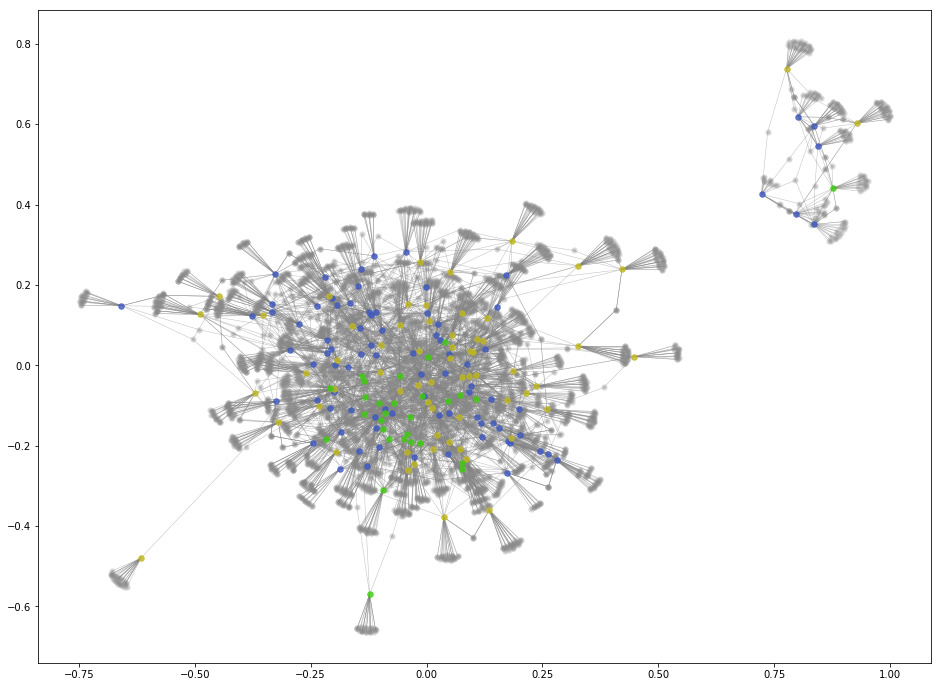

In [135]:
plot_graph(g2,pos2,
           [g2_rest, g2_SP, g2_PH, g2_DP ],
           [[(s,t) for s, t, att in g2.edges.data()],[]])

---
### Summary overlap

In [137]:
## All methods should have the same total of cases
#cases_similarity_top5.groupby(['method']).count()['source'].reset_index().head()
cases_similarity_top5.groupby(['method']).count()['source'].reset_index().tail()

,method,source
4,doc2vec_256_e30,885
5,jaccard,885
6,law2vec_200,885
7,tfidf-nostem,885
8,tfidf-quintgram-nostem,885


In [139]:
table_from_overlap_analysis = pd.read_csv('../outputdata/results4plot.csv')
table_from_overlap_analysis.head(3)

,source,target,method,source_case_topic,Similarity Type,Similarity Method,Model
0,62005CJ0326,62009CJ0077,law2vec_200,public health,Semantic,Cosine Similarity,Law2Vec Embeddings
1,62013CJ0528,62014CJ0494,law2vec_200,public health,Semantic,Cosine Similarity,Law2Vec Embeddings
2,62013CJ0011,62013CO0210,law2vec_200,public health,Semantic,Cosine Similarity,Law2Vec Embeddings


In [140]:
table_from_overlap_analysis\
    .groupby(['method'])\
    .count()['source']\
    .reset_index()\
    .sort_values('source', ascending=False)

,method,source
8,tfidf-quintgram-nostem,271
5,jaccard,250
7,tfidf-nostem,237
0,GoogleNews-300-WMD,107
2,Law2Vec-200-WMD,106
3,WMD_256_e30,74
4,doc2vec_256_e30,32
6,law2vec_200,23
1,GoogleNews_300,20


In [259]:
table_overlap_top5 = pd.merge(cases_similarity_top5, table_from_overlap_analysis, 
#table_overlap_top5 = pd.merge(casses_similarity, results_filtered, 
         how='left', 
         left_on = ['source','target','method','source_case_topic'],
         right_on = ['source','target','method','source_case_topic'])
table_overlap_top5['link'] = table_overlap_top5.source + table_overlap_top5.target

In [260]:
# table_overlap_top5\
#     .groupby(['method'])\
#     .count()['source']\
#     .reset_index()\
#     .sort_values('source', ascending=False).head()
#print(table_overlap_top5.citation_link.unique())

In [261]:
table_overlap_top5[table_overlap_top5.citation_link == True]\
    .groupby(['method'])\
    .count()['source']\
    .reset_index()\
    .sort_values('source', ascending=False)

,method,source
8,tfidf-quintgram-nostem,189
5,jaccard,184
7,tfidf-nostem,167
2,Law2Vec-200-WMD,82
0,GoogleNews-300-WMD,75
3,WMD_256_e30,66
4,doc2vec_256_e30,15
1,GoogleNews_300,12
6,law2vec_200,12


In [302]:
table_overlap_top5 = pd.merge(
    table_overlap_top5.drop(columns=['Similarity Type','Similarity Method','Model']),
    models, how='left', on='method')

In [323]:
def export4visualization(table, path):
    table.drop(columns=['index','similarity_score'])\
    .to_csv(path)
    print('Extported to {}'.format(path))

export4visualization(table_overlap_top5, '../outputdata/results4tableau.csv')

Extported to ../outputdata/results4tableau.csv


---
## Visualizing overlap of methods

In [312]:
table_overlap_top5_with_link = table_overlap_top5[table_overlap_top5['citation_link'] == True]
groupA = table_overlap_top5_with_link[(table_overlap_top5_with_link['Similarity Type']=='Semantic') &
                  (table_overlap_top5_with_link['Similarity Method']=="Word Mover's Distance")]
groupB = table_overlap_top5_with_link[(table_overlap_top5_with_link['Similarity Type']=='Semantic') &
                  (table_overlap_top5_with_link['Similarity Method']=="Cosine Similarity")]
groupC = table_overlap_top5_with_link[(table_overlap_top5_with_link['Similarity Type']=='Syntactic')]

334


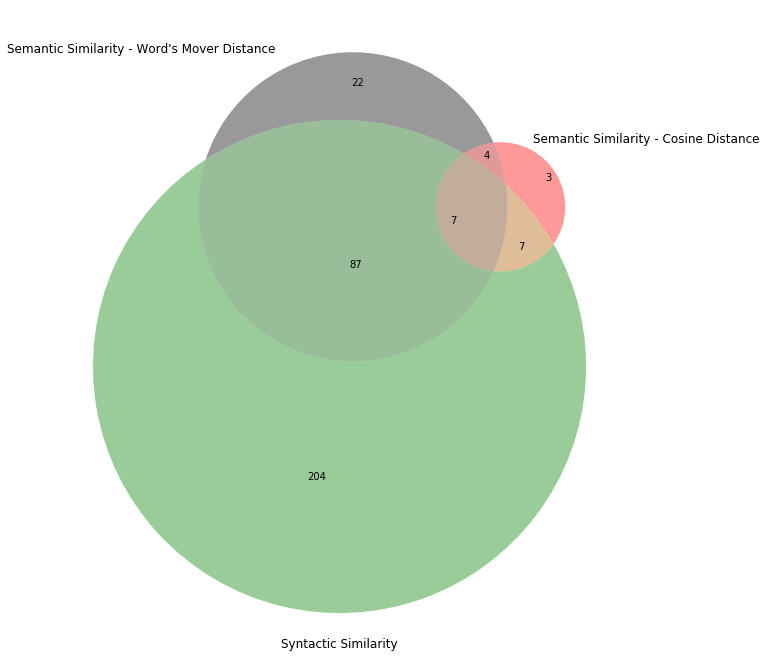

In [324]:
print(len(table_overlap_top5_with_link['link'].unique()))
plt.figure(figsize=(16, 12))
venn3([set(groupA['link']), 
       set(groupB['link']),
      set(groupC['link'])], 
      set_labels = ("Semantic Similarity - Word's Mover Distance", 'Semantic Similarity - Cosine Distance', 'Syntactic Similarity'),
      set_colors=('black', 'r', 'green'))
plt.show()
#334 distinct

---
## Intersection Graph

In [328]:
table_overlap_top5.head()

,index,source,target,similarity_score,method,citation_link,source_case_topic,link,Similarity Type,Similarity Method,Model
0,202800,62017CJ0634,62012CJ0292,0.047598,tfidf-quintgram-nostem,False,public health,62017CJ063462012CJ0292,Syntactic,Index,TF-IDF Quintgrams
1,202801,62017CJ0634,62008CJ0248,0.025486,tfidf-quintgram-nostem,False,public health,62017CJ063462008CJ0248,Syntactic,Index,TF-IDF Quintgrams
2,202802,62017CJ0634,62005CJ0176,0.018955,tfidf-quintgram-nostem,True,public health,62017CJ063462005CJ0176,Syntactic,Index,TF-IDF Quintgrams
3,202803,62017CJ0634,62013CJ0551,0.018348,tfidf-quintgram-nostem,False,public health,62017CJ063462013CJ0551,Syntactic,Index,TF-IDF Quintgrams
4,202804,62017CJ0634,61997CJ0365,0.017462,tfidf-quintgram-nostem,False,public health,62017CJ063461997CJ0365,Syntactic,Index,TF-IDF Quintgrams


---
#### Choose one method to plot

In [179]:
table_overlap_top5['method'].unique()

array(['tfidf-quintgram-nostem', 'tfidf-nostem', 'law2vec_200', 'jaccard',
       'doc2vec_256_e30', 'WMD_256_e30', 'Law2Vec-200-WMD',
       'GoogleNews_300', 'GoogleNews-300-WMD'], dtype=object)

In [181]:
method = 'jaccard'
method_table = table_overlap_top5[table_overlap_top5['method'] == method]

---
#### Creating the intersection graph

In [182]:
nodes3 = df_to_json_nodes(df_relations = method_table,
                         df_attributes = sampled_cases[['case','topic']])
g3 = graph_and_layout(method_table, nodes3) #the df of relations again
pos3 = nx.spring_layout(g3) #nx.kamada_kawai_layout(g2)
graph_description(g3)

Nodes: 770
Edges: 851
Avg Degree: 0.9048178613396005


In [183]:
g3_rest, g3_SP, g3_PH, g3_DP = groups(g3)

In [184]:
edges_citation = []
edges_similarity = []
for s, t, att in g3.edges.data():
    if (att['citation_link'] == True) & (att['method'] == method):
        edges_citation.append((s,t))
    else:
        edges_similarity.append((s,t))

In [185]:
print('Percentage of links overlap: ',len(edges_citation)/len(g3.edges))

Percentage of links overlap:  0.20211515863689777


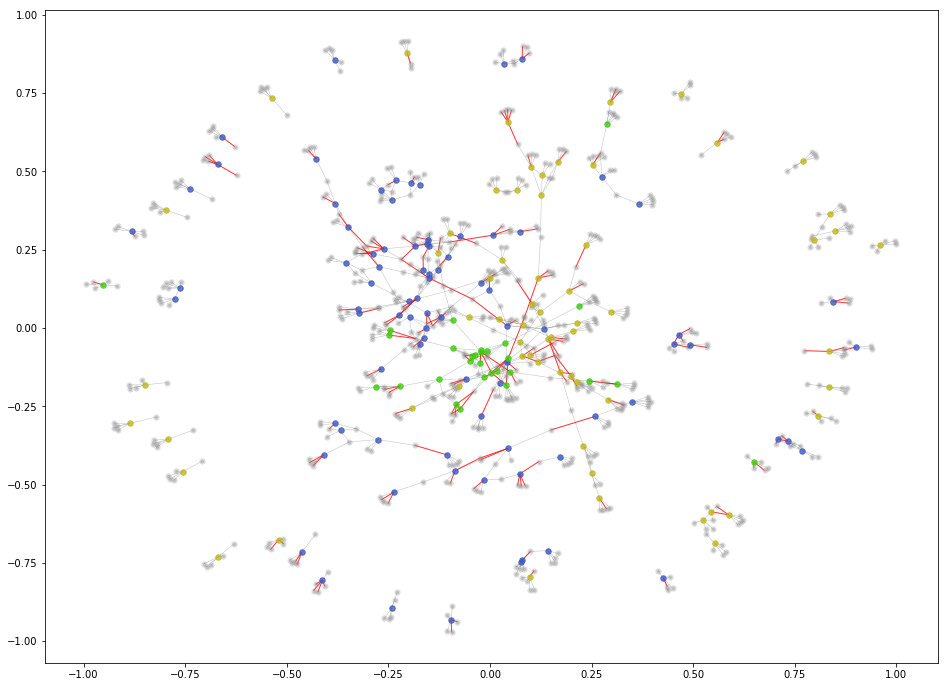

In [187]:
plot_graph(g3,pos3,
           [g3_rest, g3_SP, g3_PH, g3_DP],
           [edges_similarity,edges_citation])